In [1]:
import os, numpy as np, pandas, sklearn
import mido, rtmidi, rtmidi_
np.random.seed(333)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config
from data import data, midi
from utils import io

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
n: int = 8
context, x_train, labels = data.init(n)
print(x_train.shape)

Setting up params

 >> Context(max_t=10.0, dt=0.01, n_instances=1000, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

[INFO] :
 |  reading file: ../datasets/examples/01 16th Snare copy.mid
[INFO] :
 |  reading file: ../datasets/examples/01 16th Snare.mid
[INFO] :
 |  reading file: ../datasets/examples/01 8th Cym copy.mid
[INFO] :
 |  reading file: ../datasets/examples/01 8th Cym.mid
[INFO] :
 |  reading file: ../datasets/examples/01 8th Hat copy.mid
[INFO] :
 |  reading file: ../datasets/examples/01 8th Hat.mid
[INFO] :
 |  reading file: ../datasets/examples/02 8th Cym copy.mid
[INFO] :
 |  reading file: ../datasets/examples/02 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare copy.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym copy.mid' type 0, 1 tracks, 68 messages>, <midi file '../datasets/examples/

# Autoencoder
Input -> hidden layer -> output (=input)
Hidden layer has few dimension. Latent space of this layer should produce automatic categorization.

In [5]:
y_train = x_train
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:]
# output_length = y_train.shape[1]
# output_length = (y_train[0]).shape[0] # = length of an individual label
hidden_layer_length = 100
x_train.shape

(8, 1000, 127)

In [6]:
y_train.shape

(8, 1000, 127)

In [7]:
output_shape

(1000, 127)

In [8]:
from keras import regularizers
# functional syntax: lambda x: lambda y: z
def encoder(input_shape, output_length, dropout=0.10):
    input_layer = Input(shape=input_shape)
    x = input_layer
    x = Flatten()(x)
    x = Dense(10, activation='relu')(x)
    x = Dense(output_length, activation='sigmoid')(x)
#     x = Dense(output_length, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
    
    model = Model(inputs=input_layer, outputs=x)
    #     model.add(Dropout(dropout))
    return model, model.summary


def decoder(input_length, output_shape, dropout=0.10):
    input_layer = Input(shape=(input_length,))
    x = input_layer
    shape = (10,100) # 1 additional dimension
    x = Dense(np.prod(shape), activation='relu')(x) # 4*4*8 = 128
    x = Reshape(shape)(x)
    x = UpSampling1D(10)(x)
    x = Conv1D(100, 2, strides=2, activation='relu')(x) # 50,100
    x = UpSampling1D(output_shape[0] / 50)(x)
    x = Dense(output_shape[1], activation='relu')(x)
    x = Dense(output_shape[1], activation='relu')(x)
    x = Dense(output_shape[1], activation='relu')(x)
    #     x = LocallyConnected1D(output_shape[1], kernel_size=1, activation='relu')(x)
    # x = Dense(output_length, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=x)
    #     model.add(Dropout(dropout))
    return model, model.summary


def autoencoder(input_shape, output_shape, hidden_layer_length=10, dropout=0.10, verbose=False):
    encode, summary = encoder(input_shape, hidden_layer_length, dropout)
    if verbose:
        summary()
    decode, summary = decoder(hidden_layer_length, output_shape, dropout)
    if verbose:
        summary()
    input_ = Input(shape=input_shape)
    model = Model(input_, decode(encode(input_)))
    return encode, decode, model, model.summary


dropout = 0.
encode, decode, model, summary = autoencoder(input_shape, output_shape, hidden_layer_length, dropout, True)
# summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 127)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 127000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1270010   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               1100      
Total params: 1,271,110
Trainable params: 1,271,110
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________


In [9]:
metrics = ['accuracy','mse','categorical_crossentropy']
loss = 'binary_crossentropy'
optimizer = 'adadelta'
# learning_rate = 0.001
# optimizer = optimizer = Adam(lr=learning_rate)
# sgd = Keras.optimizers.SGD(lr=0.01, clipnorm=1.)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [10]:
batch_size = 1
# n epochs = n iterations over all the training data
epochs = 15

In [11]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
#           validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_model_dir)])

Epoch 1/15
8/8 [==============================] - 1s 129ms/step - loss: 0.3820 - acc: 0.9620 - mean_squared_error: 0.0359 - categorical_crossentropy: 48.3637
Epoch 2/15
8/8 [==============================] - 0s 59ms/step - loss: 0.2024 - acc: 0.9620 - mean_squared_error: 0.0308 - categorical_crossentropy: 27.0953
Epoch 3/15
8/8 [==============================] - 0s 59ms/step - loss: 0.1697 - acc: 0.9620 - mean_squared_error: 0.0268 - categorical_crossentropy: 23.0850
Epoch 4/15
8/8 [==============================] - 0s 61ms/step - loss: 0.1585 - acc: 0.9638 - mean_squared_error: 0.0232 - categorical_crossentropy: 22.2549
Epoch 5/15
8/8 [==============================] - 0s 60ms/step - loss: 0.1509 - acc: 0.9703 - mean_squared_error: 0.0204 - categorical_crossentropy: 21.9001
Epoch 6/15
8/8 [==============================] - 0s 61ms/step - loss: 0.1457 - acc: 0.9751 - mean_squared_error: 0.0181 - categorical_crossentropy: 21.8311
Epoch 7/15
8/8 [==============================] - 0s 62ms

In [12]:
result = encode.predict(x_train)
n = result.shape[0]
result.shape

(8, 100)

In [13]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

In [14]:
# scale/normalize data, based on features
# axis determines whether the data is scaled based on the 'global' features
# axis = 0: max per feature (between instances)
# axis = 1: max per instance (ignore features)
# e.g. np.arange(9).reshape(3,3).max(axis=0)

a = preprocessing.minmax_scale(np.arange(9).reshape(3,3), axis=0)
a

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


array([[0. , 0. , 0. ],
       [0.5, 0.5, 0.5],
       [1. , 1. , 1. ]])

In [15]:
a[:,1].mean()

0.5

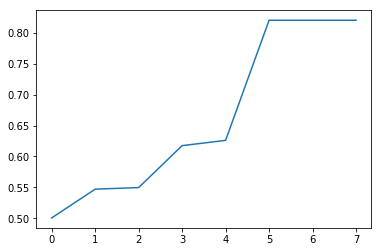

In [16]:
plt.plot(result[:,0])

In [17]:
normalized = preprocessing.normalize(result, axis=0)
# normalized = preprocessing.minmax_scale(result, axis=0)
# normalized = preprocessing.robust_scale(result, axis=0, quantile_range=(25, 75))
normalized[:,2]

array([0.25143772, 0.28007016, 0.28163487, 0.32285714, 0.32794765,
       0.43483147, 0.43483147, 0.43483147], dtype=float32)

In [18]:
result[:,2].mean()

0.6890251

In [19]:
normalized[0,:].mean()

0.41197723

In [20]:
data = normalized
data.shape

(8, 100)

In [21]:
data[:,2]

array([0.25143772, 0.28007016, 0.28163487, 0.32285714, 0.32794765,
       0.43483147, 0.43483147, 0.43483147], dtype=float32)

In [22]:
data[:2, 0]

array([0.26224333, 0.28660142], dtype=float32)

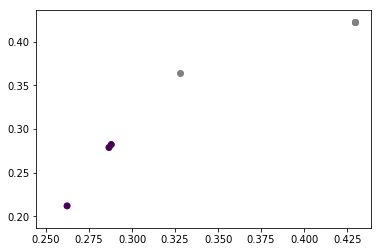

In [23]:
# plt.scatter(latent[:,0], latent[:,1], c=y_test[:num], alpha=0.1)
# plt.scatter(result[:,0],result[:,1])
plt.scatter(data[:3, 0], data[:3, 1], data='o', c=[0.4]*3)
plt.scatter(data[4:, 0], data[4:, 1], data='^', c=[0.5]*3)

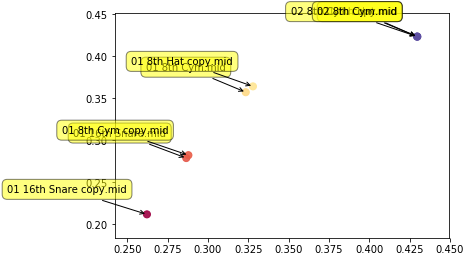

In [24]:
x_dim = 0
y_dim = 1
c_dim = 2
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    data[:, x_dim], data[:, y_dim], marker='o', c=data[:, c_dim], alpha=0.9, s=[50 for _ in range(n)],
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels, data[:, x_dim], data[:, y_dim]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

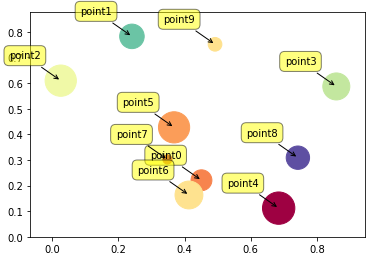

In [25]:
N = 10
np.random.seed(300)
data = np.random.random((N, 4))
labels2 = ['point{0}'.format(i) for i in range(N)]

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    data[:, 0], data[:, 1], marker='o', c=data[:, 2], s=data[:, 3] * 1500,
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels2, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

In [26]:
originals = result[0:2,]
new = np.stack([originals.mean(axis=0), originals[0]])

In [27]:
arr = decode.predict(new)
arr.shape

(2, 1000, 127)

In [28]:
midis = [midi.decode_track(context, track) for track in arr]

[INFO] :
 |  len
 |  10.437499999999952
 |  10.0
[INFO] :
 |  len
 |  10.437499999999952
 |  10.0


In [29]:
midis[0].tracks[0]

<midi track '' 14000 messages>

In [31]:
for i, mid in enumerate(midis):
    io.export_midifile(mid, '../midis/midi_%i.mid' % i)

In [32]:
labels

['01 16th Snare copy.mid',
 '01 16th Snare.mid',
 '01 8th Cym copy.mid',
 '01 8th Cym.mid',
 '01 8th Hat copy.mid',
 '01 8th Hat.mid',
 '02 8th Cym copy.mid',
 '02 8th Cym.mid']

In [41]:
from keras.models import model_from_json

def save_model(model, model_name='model'):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name + '.h5', "w")
    config.info("Saved model to disk")


In [42]:
dn = config.dataset_dir + 'models/'
save_model(model, dn + 'model')
save_model(encode, dn + 'encoder')
save_model(decode, dn + 'decoder')

[INFO] :
 |  Saved model to disk
[INFO] :
 |  Saved model to disk
[INFO] :
 |  Saved model to disk
